In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import quantbullet as qb
from quantbullet import set_figsize
import quantbullet.research.jump_model as jm

# activate the autoreload of modules
%load_ext autoreload
%autoreload 2

In [151]:
# import yfinance as yf
# ticker_symbol = "TSLA"
# data = yf.download(ticker_symbol, start="2018-01-01", end="2023-12-31")
data = pd.read_pickle('tsla_20180101_20231231.pkl')

In [152]:
log_ret = qb.compute_log_returns(data['Adj Close'])
exante_vol = qb.compute_ex_ante_volatility(log_ret)

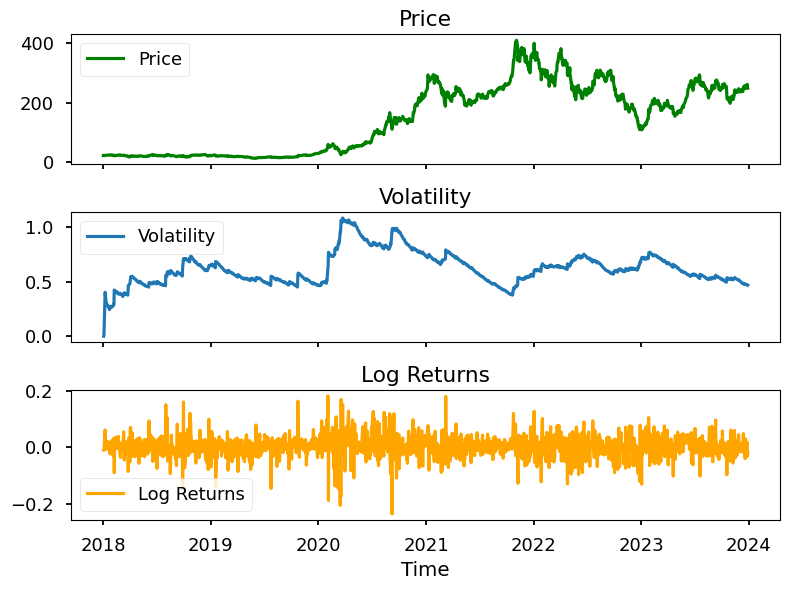

In [161]:
with plt.style.context('seaborn-talk'):
    qb.plot_price_logret_volatility(data['Adj Close'], log_ret, exante_vol, figsize=(8, 6));

## Use 2018-2020 data to model the parameters

In [179]:
price = data["Adj Close"]
log_ret = qb.compute_log_returns(price)
CUTOFF_DATE = pd.Timestamp("2020-12-31")
train_price, test_price = price.loc[:CUTOFF_DATE], price.loc[CUTOFF_DATE + pd.Timedelta(days=1):]
train_ret, test_ret = log_ret.loc[:CUTOFF_DATE], log_ret.loc[CUTOFF_DATE + pd.Timedelta(days=1):]

In [180]:
enriched_returns = jm.FeatureGenerator().enrich_features(train_ret)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)

In [181]:
ctsJump = jm.ContinuousJumpModel()
best_states, best_loss, best_thetas = ctsJump.fit(enriched_returns, k=2, lambda_=100, n_trials=10)

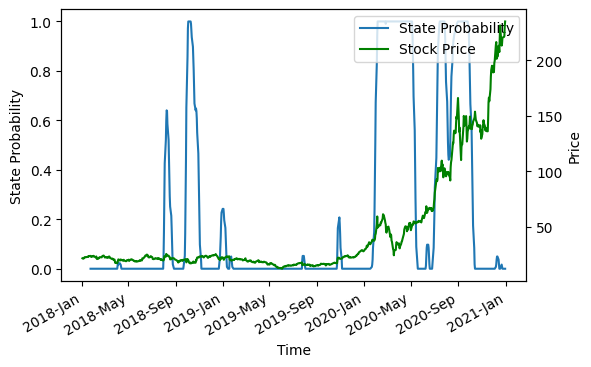

In [189]:
remapped_states, remapped_thetas = jm.arrange_state_prob_by_volatility(enriched_returns[:, 0], best_states, best_thetas, 0.5)
with set_figsize(6, 4):
    # Two states maybe flipped, so we need to rearrange them
    jm.TestingUtils().plot_state_probs(remapped_states, data['Adj Close'][:'2020-12-31'])

## Test the 2021-2023 data

Now, use the trained parameters, which are the thetas, and use a smaller lambda value, making the algorithm more reactive.

In [194]:
enriched_returns = jm.FeatureGenerator().enrich_features(test_ret)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)
test_probs = ctsJump.predict(enriched_returns, remapped_thetas, lambda_=10.)

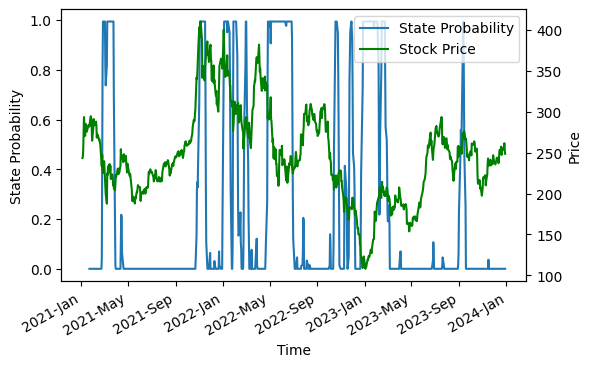

In [195]:
with set_figsize(6, 4):
    jm.TestingUtils().plot_state_probs(test_probs, test_price)

The prediction does not seem to identify same pattern every time up or down, though I do think it captured the unilateral (one-sided) market. From the volatility chart below, we see the model seems to predict well for a volatility spike.

The sharp increase in volatility may be associated with a market crash / market surge, so we see unilateral movement in the market. These observations may support a momentum strategy.

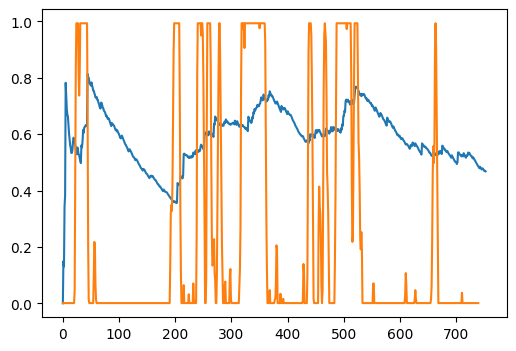

In [203]:
exante_vol = qb.compute_ex_ante_volatility(test_ret)
with set_figsize(6, 4):
    plt.plot(exante_vol.values)
    plt.plot(test_probs[:, 1])

# Momentum strategy under regimes

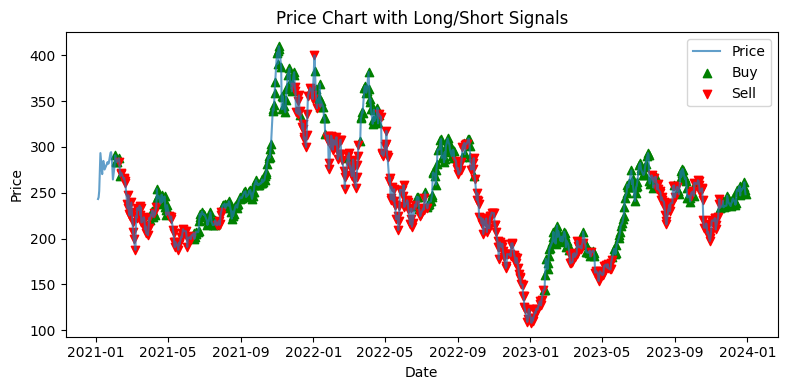

In [208]:
momentum_signal = qb.generate_ts_momentum_signal(test_ret, 20)
qb.plot_price_with_signal(test_price, momentum_signal, figsize=(8, 4));

In [209]:
if not isinstance(test_probs, pd.Series):
    test_probs = pd.Series(test_probs[:, 1], index=momentum_signal.index[13:])

In [210]:
df = pd.DataFrame(
    {
        "ts_momentum_signal": momentum_signal,
        "close": test_price,
        "state_probs": test_probs,
        "log_return": test_ret,
        "volatility": exante_vol,
        "return": np.exp(test_ret) - 1,
    }
)

In [211]:
df['momentum_return'] = df['ts_momentum_signal'] * df['return']
df['momentum_cum_return'] = (1 + df['momentum_return']).cumprod()
df['state_0_momentum_return'] = df['ts_momentum_signal'] * df['return'] * np.where(df['state_probs'] < 0.5, 1, np.nan)
df['state_0_momentum_cum_return'] = (1 + df['state_0_momentum_return'].fillna(0)).cumprod()
df['state_1_momentum_return'] = df['ts_momentum_signal'] * df['return'] * np.where(df['state_probs'] >= 0.5, 1, np.nan)
df['state_1_momentum_cum_return'] = (1 + df['state_1_momentum_return'].fillna(0)).cumprod()

In [212]:
qb.print_metrics(df['momentum_return'])

Annualized Return: 48.48%
Annualized Volatility: 58.65%
Sharp Ratio: 0.83
Max Drawdown: -42.95%
Number of Trades: 732


In [213]:
qb.print_metrics(df['state_0_momentum_return'])

Annualized Return: 58.18%
Annualized Volatility: 49.54%
Sharp Ratio: 1.17
Max Drawdown: -42.64%
Number of Trades: 566


In [214]:
qb.print_metrics(df['state_1_momentum_return'])

Annualized Return: 15.62%
Annualized Volatility: 82.54%
Sharp Ratio: 0.19
Max Drawdown: -53.10%
Number of Trades: 166


There are indeed differences in performance. By circumventing the regime with high volatilities, the sharpe is boosted.

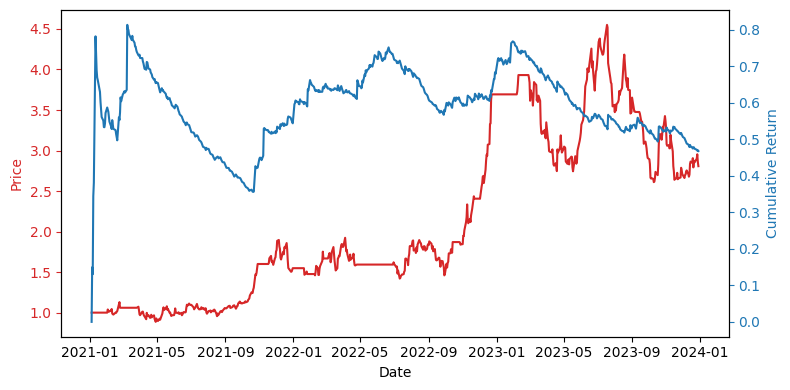

In [222]:
with set_figsize(8, 4):
    qb.plot_shared_x(
        df.index,
        df["state_0_momentum_cum_return"],
        df["volatility"],
        xlabel="Date",
        ylabel1="Price",
        ylabel2="Cumulative Return",
    )

# Mean Reversion Strategy

## OU Process on the Excess Return

This approach assumes that the cumulative excess return series is staionary and follows a mean reversion pattern that can be modeled by an OU process. So there are two steps here.

- A benchmark model to get the excess return - we use the FF five factors which are easy to get.
- Get the rolling OU process parameters. This is essentially done by using its equivalence with an AR(1) model.

The solution of OU process at any time is actually a variable of Normal distribution and that is how we can find the degree of deviation.

In [2]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from collections import namedtuple
import matplotlib.pyplot as plt
import quantbullet as qb

In [224]:
ff5 = pd.read_pickle('fama_french_five_factors_20180101_20231231.pkl')
tsla = pd.read_pickle('tsla_20180101_20231231.pkl')['Adj Close']

In [225]:
tsla_log_ret = qb.compute_log_returns(tsla)
calendar = qb.BacktestingCalendar(tsla.index)
ff5_provider = qb.SimpleDataProvider(ff5)
tsla_provider = qb.SimpleDataProvider(tsla_log_ret)

Below is the first step of getting excess returns.

In [226]:
res = list()
OFFSET_DAYS = 152
calendar.set_current_date(datetime.date(2019, 1, 4))
OBS = namedtuple('OBS', ['date', 'resid', 'rsquared', 'f_pvalue'])
for date in calendar:
    backtest_start = calendar.get_offset_date(-OFFSET_DAYS)
    backtest_end = date
    X = ff5_provider.get_historical_data(backtest_start, backtest_end)
    y = tsla_provider.get_historical_data(backtest_start, backtest_end)
    model = qb.ols_regression(X, y)
    obs = OBS(date=date,
              resid=model.resid.loc[date], 
              rsquared=model.rsquared, 
              f_pvalue=model.f_pvalue)
    res.append(obs)

In [5]:
df = pd.DataFrame(res, columns=OBS._fields).set_index('date')
df['cum_excess_return'] = (1 + df['resid']).cumprod()

In [6]:
cum_excess_return = df['cum_excess_return']
calendar = qb.BacktestingCalendar(cum_excess_return.index)
excess_return_provider = qb.SimpleDataProvider(cum_excess_return)

The second step is to estimate the OU parameters and construct the upper and lower bounds.

In [7]:
res = list()
OFFSET_DAYS = 252
calendar.set_current_date(datetime.date(2021, 1, 4))
OBS = namedtuple("OBS", ["date", "mu", "theta", "sigma"])
for date in calendar:
    backtest_start = calendar.get_offset_date(-OFFSET_DAYS)
    backtest_end = date
    X = excess_return_provider.get_historical_data(backtest_start, backtest_end)
    model = qb.OrnsteinUhlenbeck()
    model.fit(X)
    obs = OBS(date=date, mu=model.mu, theta=model.theta, sigma=model.sigma)
    res.append(obs)

In [8]:
tsdf = pd.DataFrame(res, columns=OBS._fields).set_index('date')
tsdf = model.generate_bands(tsdf, 1.96)
tsdf['original'] = cum_excess_return

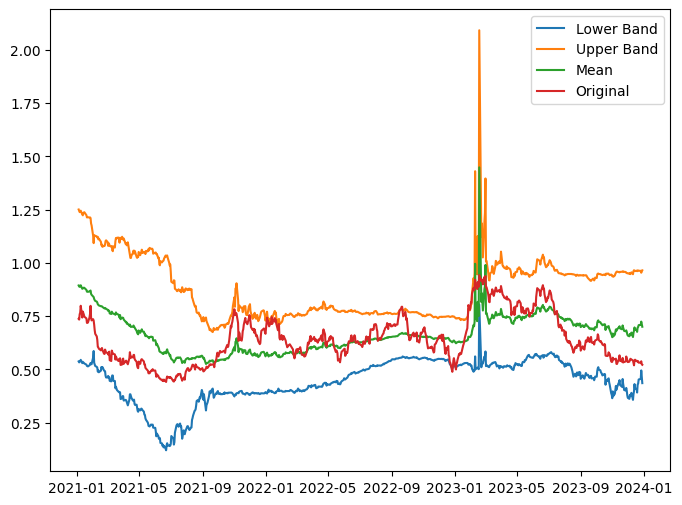

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(tsdf['lower_band'], label='Lower Band')
ax.plot(tsdf['upper_band'], label='Upper Band')
ax.plot(tsdf['mu'], label='Mean')
ax.plot(tsdf['original'], label='Original')
plt.legend()

In [10]:
tsdf['signal'] = np.where(tsdf['original'] >= tsdf['upper_band'], -1, np.nan)
tsdf['signal'] = np.where(tsdf['original'] <= tsdf['lower_band'], 1, tsdf['signal'])

This is not ideal because the signals are too sparse, not informative enough for us to compare regimes.

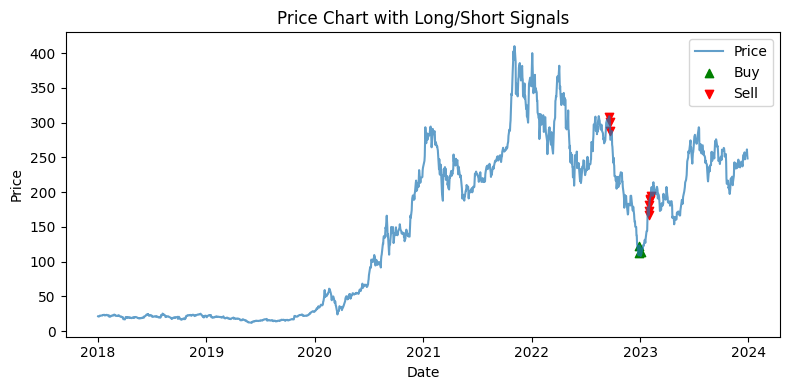

In [229]:
qb.plot_price_with_signal(tsla, tsdf['signal'].shift(1), figsize=(8, 4));

## Bollinger Bands

Thus, we go to another mean reversion model, the bollinger bands, using rolling 20 days mean and twice of the standard deviation as the upper and lower bounds.

In [249]:
bollingerBandsStrategy = qb.BollingerBands(window=60, num_std=2)
df = bollingerBandsStrategy.generate_bands(tsla)

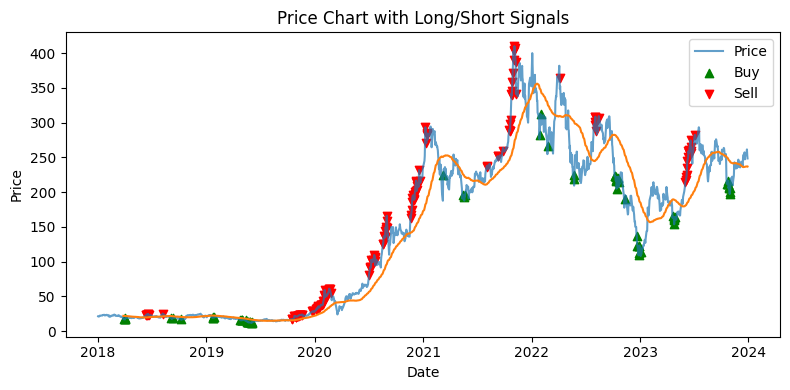

In [250]:
fig, ax = qb.plot_price_with_signal(df['price'], df['signal'].shift(1), figsize=(8,4))
ax.plot(df['rolling_mean']);

### Backtesting

Notice that what we got in the last step is just the signals, and we still need some logic to clear the position if the deviation is narrowed. The logic here depends on the position and path-depenent, therefore we have to run a backtesting.

To run the backtest, we need three things.
- A calendar
- Signal to long / short
- Signal to close the position

In [251]:
calendar = qb.BacktestingCalendar(df['price'].index)
long_short_signal = df['signal'].shift(1)
CLOSING_THRESHOLD = 1
closing_signal = np.where(np.abs(df['deviation']) < CLOSING_THRESHOLD, 1, 0)
closing_signal = pd.Series(closing_signal, index=long_short_signal.index).shift(1)
long_short_provider = qb.SimpleSignalProvider(long_short_signal)
closing_provider = qb.SimpleSignalProvider(closing_signal)

In [252]:
backtester = qb.SimpleBacktest(calendar, long_short_provider, closing_provider)
backtester.run()

1509it [00:00, 20485.52it/s]


In [253]:
positions = [ (x.date, x.shares) for x in backtester.position_history]
btdf = pd.DataFrame(positions, columns=['date', 'shares']).set_index('date')

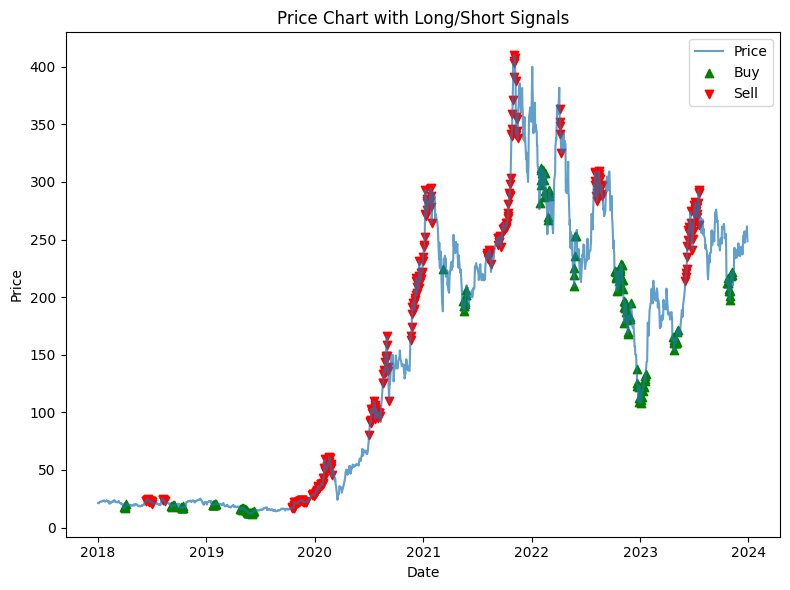

In [254]:
qb.plot_price_with_signal(df['price'], btdf['shares'], figsize=(8, 6));

In [265]:
df['position'] = btdf['shares']
df['simple_return'] = df['price'].pct_change()
df['cum_return'] = (1 + df['simple_return'] * df['position']).cumprod()
df['train_test_flag'] = np.where(df.index < pd.Timestamp('2021-01-01'), 0, 1)
df['state_probs'] = test_probs

In [268]:
df["state_0_mr_return"] = (
    df["position"] * df["simple_return"] * np.where(df["state_probs"] < 0.5, 1, np.nan)
)
df["state_0_mr_cum_return"] = (1 + df["state_0_mr_return"].fillna(0)).cumprod()

df["state_1_mr_return"] = (
    df["position"] * df["simple_return"] * np.where(df["state_probs"] >= 0.5, 1, np.nan)
)
df["state_1_mr_cum_return"] = (1 + df["state_1_mr_return"].fillna(0)).cumprod()

In [266]:
qb.print_metrics(df['simple_return'] * df['position'] * df['train_test_flag'])

Annualized Return: 2.77%
Annualized Volatility: 25.37%
Sharp Ratio: 0.11
Max Drawdown: -44.51%
Number of Trades: 248


In [269]:
qb.print_metrics(df['state_0_mr_return'])

Annualized Return: -27.19%
Annualized Volatility: 27.67%
Sharp Ratio: -0.98
Max Drawdown: -64.68%
Number of Trades: 175


In [270]:
qb.print_metrics(df['state_1_mr_return'])

Annualized Return: 147.27%
Annualized Volatility: 52.38%
Sharp Ratio: 2.81
Max Drawdown: -12.24%
Number of Trades: 60


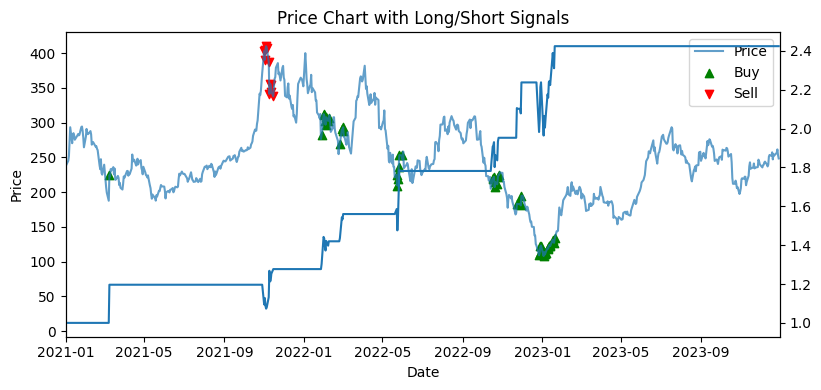

In [288]:
fig, ax = qb.plot_price_with_signal(
    df["price"],
    df["position"]
    * df["train_test_flag"]
    * np.where(df["state_probs"] >= 0.5, 1, np.nan),
    figsize=(8, 4),
);

ax2 = ax.twinx()
ax2.plot(df['state_1_mr_cum_return'])

plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2023-12-31'));